Used metrics:
t(threshold)
AP(Average Precision)
mIOU(mean IOU)
IOUfg(Foreground IOU only)

In [1]:
import torch
import torchmetrics
import torchvision.transforms as transforms

c:\Users\yitao\.conda\envs\test\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# Load ground truth
MASKS_PATH = "./dataset/masks/"
GT_PATH = MASKS_PATH + "gt/"
CLIP_PATH = MASKS_PATH + "clipseg/"
DSS_PATH = MASKS_PATH + "dss/"
RESULTS_PATH = "./results/"

In [6]:
import pandas as pd

# 创建一个空的DataFrame
data = {"filename": [], "threshold": [], "IOU": [], "AP": []}
df = pd.DataFrame(data)

# 保存DataFrame为一个CSV文件
df.to_csv("./results/scores_clipseg.csv", index=False)

In [7]:
from myutils.img_loader import get_imgNames

img_names = get_imgNames()


def toBinary(pred):
    one = torch.ones_like(pred)
    zero = torch.zeros_like(pred)
    pred_bi = torch.where(pred > 0, one, zero)
    return pred_bi

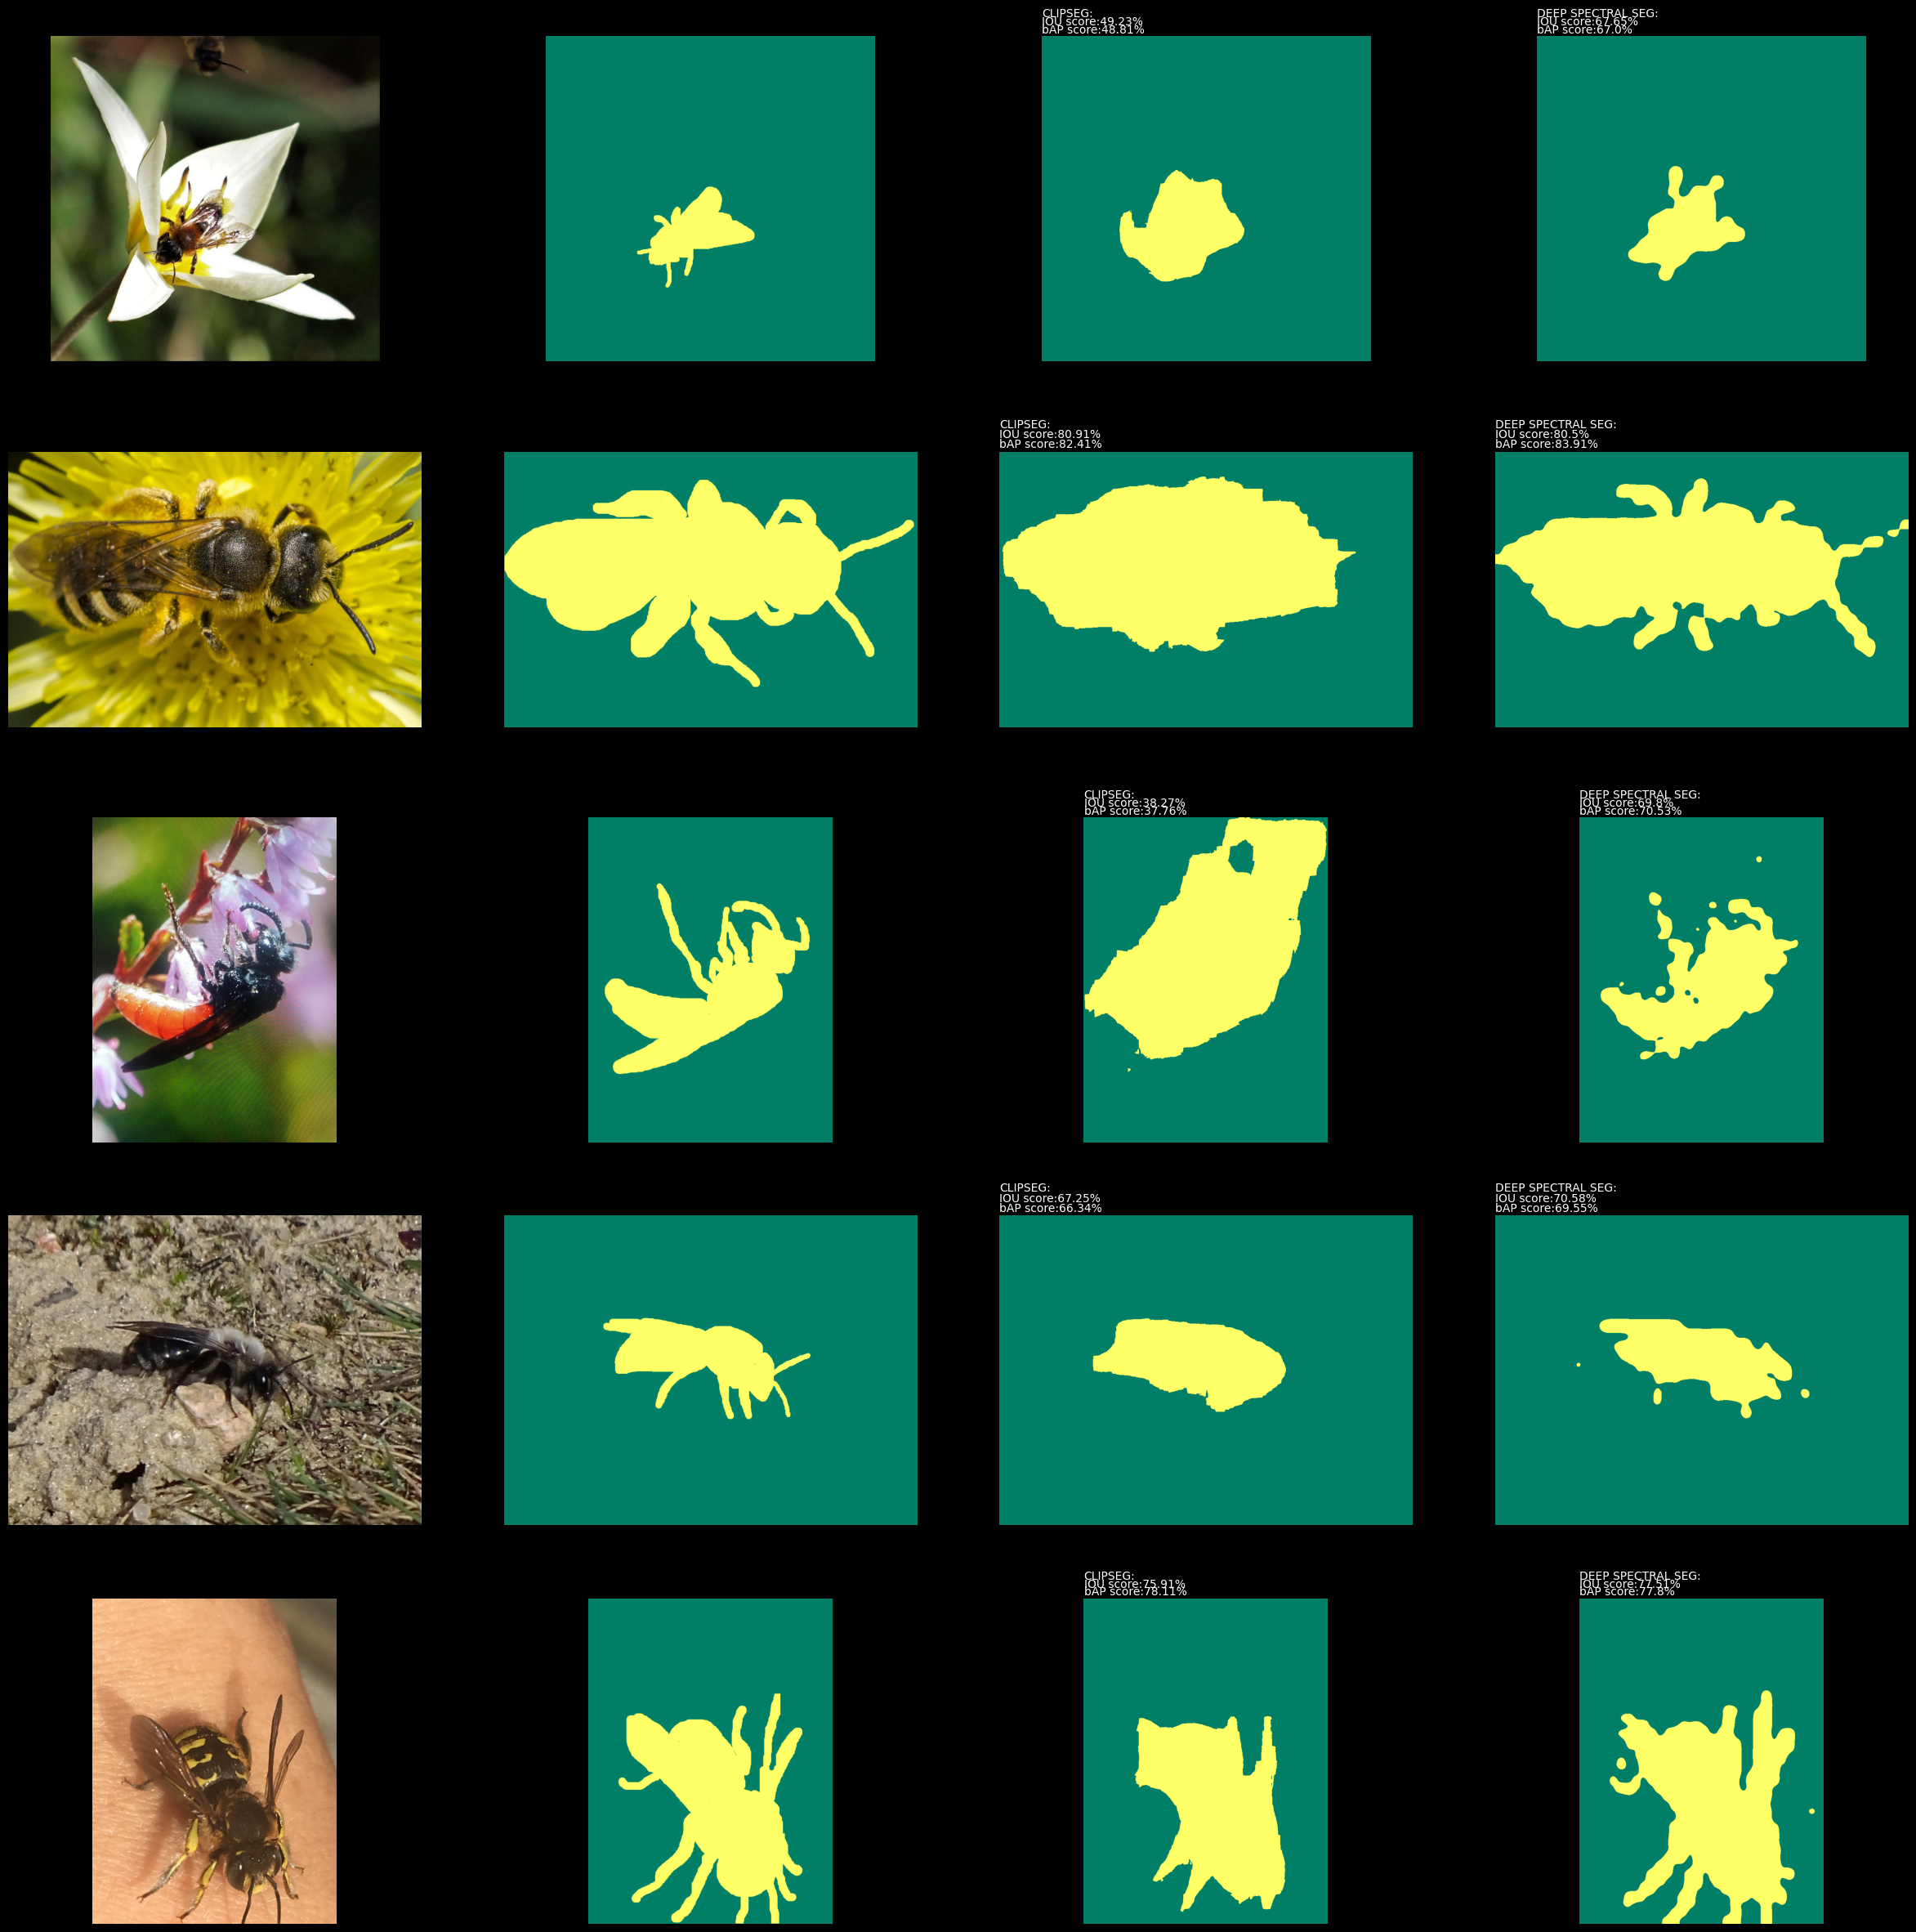

In [8]:
import random
import matplotlib.pyplot as plt
from myutils.img_loader import get_img_by_id
from torchmetrics.classification import BinaryJaccardIndex, BinaryAveragePrecision

showcases = []
toTensor = transforms.ToTensor()
num_showcases = 5
scores = []
metric_biJ = BinaryJaccardIndex()
metric_biAP = BinaryAveragePrecision(thresholds=None)

for i in range(num_showcases):
    showcase = []
    score = []
    id = random.randint(1, len(img_names))
    showcase.append(get_img_by_id(id))
    showcase.append(toTensor(get_img_by_id(id, GT_PATH)).squeeze(0))
    showcase.append(toTensor(get_img_by_id(id, CLIP_PATH + "0.8/", "png")).squeeze(0))
    showcase.append(toTensor(get_img_by_id(id, DSS_PATH + "0/0.28/", "png")).squeeze(0))
    score.append(str(round(metric_biJ(showcase[2], showcase[1].long()).item() * 100, 2)) + "%")
    score.append(str(round(metric_biAP(showcase[2], showcase[1].long()).item() * 100, 2)) + "%")
    score.append(str(round(metric_biJ(showcase[3], showcase[1].long()).item() * 100, 2)) + "%")
    score.append(str(round(metric_biAP(showcase[3], showcase[1].long()).item() * 100, 2)) + "%")

    showcases.append(showcase)
    scores.append(score)

_, ax = plt.subplots(num_showcases, len(showcases[0]), figsize=(30, 30))
[a.axis("off") for a in ax.flatten()]
for j in range(num_showcases):
    [ax[j][i].imshow(showcases[j][i], cmap="summer") for i in range(4)]
    ax[j][2].text(0, -60, "CLIPSEG:")
    ax[j][2].text(0, -35, "IOU score:" + scores[j][0])
    ax[j][2].text(0, -10, "bAP score:" + scores[j][1])
    ax[j][3].text(0, -60, "DEEP SPECTRAL SEG:")
    ax[j][3].text(0, -35, "IOU score:" + scores[j][2])
    ax[j][3].text(0, -10, "bAP score:" + scores[j][3])

In [13]:
from torchmetrics.classification import BinaryAveragePrecision

# calculate overall IOU for DEEP_SPECTRAL_SEGMENTATION


metric_IOU = BinaryJaccardIndex()
metric_biAP = BinaryAveragePrecision(thresholds=None)

thresholds = [0.2, 0.25, 0.28, 0.3, 0.32, 0.35, 0.38, 0.4, 0.42, 0.45]

print("Calculating IOUs: ")
for t in thresholds:
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_dss = get_img_by_id(i + 1, DSS_PATH + "0/" + str(t) + "/", "png")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_dss = toBinary(toTensor(img_dss).squeeze(0))
        iou = round(metric_IOU(mask_dss, mask_gt).item() * 100, 2)
        biap = round(metric_biAP(mask_dss, mask_gt.long()).item() * 100, 2)
        new_data = [{"filename": img_names[i], "threshold": t, "IOU": iou, "AP": biap}]
        new_df = pd.DataFrame(new_data)
        df = pd.concat([df, new_df], ignore_index=True)
    df.to_csv("./results/scores.csv", index=False)

Calculating IOUs: 


In [10]:
from torchmetrics.classification import BinaryAveragePrecision

# calculate overall IOU for DEEP_SPECTRAL_SEGMENTATION


metric_IOU = BinaryJaccardIndex()
metric_biAP = BinaryAveragePrecision(thresholds=None)

thresholds = [0.1, 0.11, 0.12, 0.13, 0.15, 0.2, 0.25]

print("Calculating IOUs: ")
for t in thresholds:
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_clip = get_img_by_id(i + 1, CLIP_PATH + str(t) + "/")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_clip = toBinary(toTensor(img_clip).squeeze(0))
        iou = round(metric_IOU(mask_clip, mask_gt).item() * 100, 2)
        biap = round(metric_biAP(mask_clip, mask_gt.long()).item() * 100, 2)
        new_data = [{"filename": img_names[i], "threshold": t, "IOU": iou, "AP": biap}]
        new_df = pd.DataFrame(new_data)
        df = pd.concat([df, new_df], ignore_index=True)
    df.to_csv("./results/scores_clipseg.csv", index=False)

Calculating IOUs: 


In [14]:
# calculate overall IOU for CLIPSEG

metric = BinaryJaccardIndex()

thresholds = [0.1, 0.11, 0.12, 0.13, 0.15, 0.2, 0.25]
overall_ious = []

print("OVERALL IOUs: ")
for t in thresholds:
    ious = []
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_clip = get_img_by_id(i + 1, CLIP_PATH + str(t) + "/")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_clip = toBinary(toTensor(img_clip).squeeze(0))
        iou = round(metric(mask_clip, mask_gt).item() * 100, 2)
        new_row = [{'filename': img_names[i], 'threshold': t, 'iou'}]
        ious.append(iou)

    overall_iou = round(sum(ious) / len(ious), 2)
    overall_ious.append(overall_iou)
    print("threshold = " + str(t) + ": overall IOU = " + str(overall_iou))

OVERALL IOUs: 
threshold = 0.1: overall IOU = 59.93
threshold = 0.11: overall IOU = 60.52
threshold = 0.12: overall IOU = 60.89
threshold = 0.13: overall IOU = 61.1
threshold = 0.15: overall IOU = 61.11
threshold = 0.2: overall IOU = 59.44
threshold = 0.25: overall IOU = 56.25


In [12]:
# calculate overall IOU for CLIPSEG

metric = BinaryJaccardIndex()

thresholds = [0.75, 0.77, 0.8, 0.81, 0.82, 0.83, 0.85]
overall_ious = []

print("OVERALL IOUs: ")
for t in thresholds:
    ious = []
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_clip = get_img_by_id(i + 1, CLIP_PATH + str(t) + "/", "png")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_clip = toBinary(toTensor(img_clip).squeeze(0))
        iou = round(metric(mask_clip, mask_gt).item() * 100, 2)
        ious.append(iou)

    overall_iou = round(sum(ious) / len(ious), 2)
    overall_ious.append(overall_iou)
    print("threshold = " + str(t) + ": overall IOU = " + str(overall_iou))

OVERALL IOUs: 
threshold = 0.75: overall IOU = 67.4
threshold = 0.77: overall IOU = 67.61
threshold = 0.8: overall IOU = 66.65
threshold = 0.81: overall IOU = 65.99
threshold = 0.82: overall IOU = 65.08
threshold = 0.83: overall IOU = 63.99
threshold = 0.85: overall IOU = 61.11


In [8]:
from torchmetrics.classification import BinaryAveragePrecision

# calculate overall Binary AP for CLIPSEG

metric_biAP = BinaryAveragePrecision(thresholds=None)

thresholds = [0.1, 0.11, 0.12, 0.13, 0.15, 0.2, 0.25]
overall_biaps = []

print("OVERALL binary APs: ")
for t in thresholds:
    biaps = []
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_clip = get_img_by_id(i + 1, CLIP_PATH + str(t) + "/")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_clip = toBinary(toTensor(img_clip).squeeze(0))
        biap = round(metric_biAP(mask_clip, mask_gt.long()).item() * 100, 2)
        biaps.append(biap)

    overall_biap = round(sum(biaps) / len(biaps), 2)
    overall_biaps.append(overall_biap)
    print("threshold(" + str(t) + ") | overall binay AP = " + str(overall_biap))

OVERALL binary APs: 
threshold(0.1) | overall binay AP = 60.68
threshold(0.11) | overall binay AP = 61.4
threshold(0.12) | overall binay AP = 61.9
threshold(0.13) | overall binay AP = 62.27
threshold(0.15) | overall binay AP = 62.6
threshold(0.2) | overall binay AP = 61.83
threshold(0.25) | overall binay AP = 59.66


In [15]:
from torchmetrics.classification import BinaryAveragePrecision

# calculate overall Binary AP for CLIPSEG

metric_biAP = BinaryAveragePrecision(thresholds=None)

thresholds = [0.75, 0.77, 0.8, 0.81, 0.82, 0.83, 0.85]
overall_biaps = []

print("OVERALL binary APs: ")
for t in thresholds:
    biaps = []
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_clip = get_img_by_id(i + 1, CLIP_PATH + str(t) + "/", "png")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_clip = toBinary(toTensor(img_clip).squeeze(0))
        biap = round(metric_biAP(mask_clip, mask_gt.long()).item() * 100, 2)
        biaps.append(biap)

    overall_biap = round(sum(biaps) / len(biaps), 2)
    overall_biaps.append(overall_biap)
    print("threshold(" + str(t) + ") | overall binay AP = " + str(overall_biap))

OVERALL binary APs: 
threshold(0.75) | overall binay AP = 67.93
threshold(0.77) | overall binay AP = 68.45
threshold(0.8) | overall binay AP = 68.15
threshold(0.81) | overall binay AP = 67.75
threshold(0.82) | overall binay AP = 67.12
threshold(0.83) | overall binay AP = 66.33
threshold(0.85) | overall binay AP = 64.14


In [13]:
# calculate overall IOU for DEEP_SPECTRAL_SEGMENTATION


metric = BinaryJaccardIndex()

thresholds = [0.2, 0.25, 0.28, 0.3, 0.32, 0.35, 0.38, 0.4, 0.42, 0.45]
overall_ious = []

print("OVERALL IOUs: ")
for t in thresholds:
    ious = []
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_dss = get_img_by_id(i + 1, DSS_PATH + "0/" + str(t) + "/", "png")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_dss = toBinary(toTensor(img_dss).squeeze(0))
        iou = round(metric(mask_dss, mask_gt).item() * 100, 2)
        ious.append(iou)

    overall_iou = round(sum(ious) / len(ious), 2)
    overall_ious.append(overall_iou)
    print("threshold = " + str(t) + ": overall IOU = " + str(overall_iou))

OVERALL IOUs: 
threshold = 0.2: overall IOU = 71.22
threshold = 0.25: overall IOU = 72.32
threshold = 0.28: overall IOU = 72.27
threshold = 0.3: overall IOU = 72.08
threshold = 0.32: overall IOU = 71.81
threshold = 0.35: overall IOU = 71.21
threshold = 0.38: overall IOU = 70.41
threshold = 0.4: overall IOU = 69.76
threshold = 0.42: overall IOU = 69.03
threshold = 0.45: overall IOU = 67.81


In [6]:
from torchmetrics.classification import BinaryAveragePrecision

# calculate overall Binary AP for DEEPSPEC

metric_biAP = BinaryAveragePrecision(thresholds=None)

thresholds = [0.2, 0.25, 0.28, 0.3, 0.32, 0.35, 0.38, 0.4, 0.42, 0.45]
overall_biaps = []

print("OVERALL binary APs: ")
for t in thresholds:
    biaps = []
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_dss = get_img_by_id(i + 1, DSS_PATH + "0/" + str(t) + "/", "png")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_dss = toBinary(toTensor(img_dss).squeeze(0))
        biap = round(metric_biAP(mask_dss, mask_gt.long()).item() * 100, 2)
        biaps.append(biap)

    overall_biap = round(sum(biaps) / len(biaps), 2)
    overall_biaps.append(overall_biap)
    print("threshold(" + str(t) + ") | overall binay AP = " + str(overall_biap))

OVERALL binary APs: 
threshold(0.2) | overall binay AP = 71.66
threshold(0.25) | overall binay AP = 73.15
threshold(0.28) | overall binay AP = 73.35
threshold(0.3) | overall binay AP = 73.33
threshold(0.32) | overall binay AP = 73.24
threshold(0.35) | overall binay AP = 72.92
threshold(0.38) | overall binay AP = 72.42
threshold(0.4) | overall binay AP = 71.98
threshold(0.42) | overall binay AP = 71.45
threshold(0.45) | overall binay AP = 70.54


Problems:
1. choose of threshold
2. The images were stored with 0 and 1s, but when reloading the images, it became float
Ideas:
1. (DEEPSPEC) union of different eigenvectors
2. evaluate image query
